In [1]:
'''
PROGRAM TO CREATE IMAGES FOR ROBOAO 'MASTER' GUI
------------------------------------------------
Prompts user for path to directories for each individual target
Each directory should be formatted as the 'source data' from online database
100p.fits must be 2048x2048

Program returns 4 png images for each target saved in that target's directory:
1. BW, log-scaled, full fits field of view for target position selection
2. Database image from DSS for position check
3. Fits collage containing 2 differently scaled images (BW, color) and 
   2 psf-subtracted images (BW, color) for close-companion position selector
4. Color-scaled image out to 4 arcseconds for distant-companions

'''

import matplotlib
matplotlib.use('agg')

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from shutil import copyfile
import glob, re, urllib, PIL, os, astropy.stats
from PIL import Image, ImageDraw

In [2]:
#path to data directories containing 'source data' from online database for each target
#pa = "/data/roboao_user/claire/allTargets/"
pa = "C:/Users/Claire/Documents/Research/Robo-AO/Data/source/"
path = pa+"3_*"
nwfl = pa+'cct_0.06_0.085'
nlist = [s for s in os.listdir(pa) if s.startswith('3_')]                     #make list of directory path

In [6]:
sad=0
cctH = 0.085                                                            #core cut high
cctL = 0.06                                                         #core cut low
if not os.path.exists(nwfl):
    os.mkdir(nwfl)
arcssp = 1.5                                                        #arc seconds across total image for fits collage
sp = arcssp*(1000./(17.4*2.))                                       #converting arcsec to pixels on either side of target
trgtlst = sorted(glob.glob(path))
k=0                                                                 #Make sure all plots are seperate
m=1                                                                 #keep track of loop
for j in trgtlst:                                                   #loop over every target directory
    
    name=(j.split("/")[-1]).split("\\")[1]
    print 'Working on: ' + name +',  '+str(m)+'/'+str(len(trgtlst))   #print current target and progress
    
    #ONLY LOOK AT OBJECTS WITH cctL =< CORE < cctH
    stinfo = sorted(glob.glob(j + '/automated/strehl/*.txt'))
    try:
        with open(stinfo[0], 'r') as st:
            tinf = st.readlines()[1].split()            #target info
    except IndexError:
        print '^something wrong with info file, skipping'
        sad+=1

    if (float(tinf[2])>=cctL) and ((float(tinf[2]))<cctH):                      #only do targets with specified core size
        ntd = nwfl+'/'+name                      #new target directory
        if not os.path.exists(ntd):
            os.mkdir(ntd)
        else:                                                       #this script is sometimes (apparently) randomly killed
            print j.split("/")[-1]+' already done'                  #...when running on Caltech so this skips
            m+=1                                                    #targets which already have a gui file for re-running
            continue
        print j.split("/")[-1]+' has passed cut'
        
    else:
        m+=1
        continue
    
    #LOADING FILES
    fts = j+'/automated/100p.fits'                                          #100p fits file
    ftsim= fits.getdata(fts)                                                #load fits file and store as array
    old = np.seterr(invalid='ignore')                                       #ignore invalid values for taking log in next line
    ftslg = np.log(ftsim+.4)                                                #for log plots
    ftslgn = np.log(ftsim+50)
    np.seterr(**old)                                                        #restore settings to not ignore invalid values
    try:
        psf = fits.getdata((sorted(glob.glob(j+'/automated/pca/*.fits')))[0])   #load psf fits file and store as array
    except IndexError:
        print '^trouble with psf, skipping'
        sad+=0
    
    try:
        contcurv = sorted(glob.glob(j+'/automated/pca/*curve.png'))
        copyfile(contcurv[0], ntd+'/contrast_curve.png')
    except IndexError:
        print '^ something wrong with contrast curve, skipping'
        sad+=0
    
    #CREATE ONE TEXT FILE FOR GUI
    tinfr = []                                      #Blank array to store target info
    for i in tinf:
        if i != tinf[-1] and i != tinf[-2]:         #Remove tag and FWHM, last two items in strehl txt
            tinfr.append(round(float(i), 2))        #round to two sf, convert back to string
    hdulist = fits.open(fts)
    tinfr.append(hdulist[0].header['MAGNITUD'])     #Get object magnitude from header
    np.savetxt(ntd+'/info4GUI.txt', tinfr)
    
    xpix = int(tinfr[1])                            #get pixel coordinates of target
    ypix = int(tinfr[0])
    xpsf = 100                                      #pixel coordinates of target for psf images
    ypsf = 100                                      #..since psf has target centered
        
    #PNG FROM FITS FOR POSITION FINDER    
    fig = plt.figure(k, frameon=False)
    fig.set_size_inches(10,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    ax.imshow(ftslg, cmap='gray', vmin=-2.e0, vmax=2.e0)               #log plot, vmin and max to adjust scaling
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.plot(xpix-220, ypix, 's', marker='_', mew=4, ms=20, color='lawngreen')      #mark target's position by pixel coordinates
    plt.plot(xpix+220, ypix, 's', marker='_', mew=4, ms=20, color='lawngreen')      #(position, marker, thicknes, length, color)
    plt.savefig(ntd+'/locda.png', dpi=100, bbox_inches='tight', pad_inches=0)      #save plot
    im = PIL.Image.open(ntd+'/locda.png')                                             #reopen image to edit with pil
    im = im.convert("RGB")
    im = im.transpose(PIL.Image.FLIP_TOP_BOTTOM)
    im.save(ntd+'/locda.png', "PNG") 
    im.close()
    
    
    #IMAGE FROM DSS DATABASE
    p=fits.open(fts)                                                              #load fits file
    ra = p[0].header['OBJRA'].replace('h',':').replace('m', ':').replace('s','')    #find ra and dec in header
    dec = p[0].header['OBJDEC'].replace('d',':').replace('m', ':').replace('s','')
    #url to image location, h & w are in arc minutes, Fov=roboaoFov*2.5
    DSSad = "http://archive.stsci.edu/cgi-bin/dss_search?v=poss2ukstu_red&r="+ra+"&d="+dec+"&e=J2000&h=1.4848&w=1.4848&f=gif&c=none&fov=NONE&v3="
    urllib.urlretrieve(DSSad, j+'/locdb.png')                                       #save dss image as png
    im = PIL.Image.open(j+'/locdb.png')                                             #reopen image to edit with pil
    im = im.convert("RGB")
    im = im.transpose(PIL.Image.FLIP_LEFT_RIGHT)                                    #flip image to match roboao data
    draw = ImageDraw.Draw(im)  
    cx = im.size[0]/2                                                               #coordinates of image's center
    cy = im.size[1]/2
    draw.line((cx-10,cy,cx-7,cy),fill=(50, 205, 50))                                #mark image center (target)
    draw.line((cx+10,cy,cx+7,cy),fill=(50, 205, 50))
    draw.rectangle([cx*3/5, cy*3/5, 7*cx/5, 7*cy/5], outline=(52, 40, 44))          #draw square around roboao field (2/5 dimnsns)
    del draw
    im.save(ntd+'/locdb.png', "PNG") 
    im.close()
    
    #FITS COLLAGE (4 pngs)
    fig = plt.figure(k+1, frameon=False)
    fig.set_size_inches(10,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    ax.imshow(ftsim, cmap='gray')                              #black and white original fits
    plt.xlim(xpix-sp, xpix+sp)                                 #crop plot based on arcsec specifications
    plt.ylim(ypix-sp, ypix+sp)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.savefig(ntd+'/fc1.png', dpi=100, bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure(k+2, frameon=False)
    fig.set_size_inches(10,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    ax.imshow(-ftsim, cmap='RdYlBu')                           #color scale original fits
    plt.xlim(xpix-sp, xpix+sp)                                 #crop plot based on arcsec specifications
    plt.ylim(ypix-sp, ypix+sp)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.savefig(ntd+'/fc2.png', dpi=100, bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure(k+6, frameon=False)
    fig.set_size_inches(10,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    ax.imshow(psf, cmap='gray')                                #black and white psf
    plt.xlim(xpsf-sp, xpsf+sp)
    plt.ylim(ypsf-sp, ypsf+sp)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.savefig(ntd+'/fc3.png', dpi=100, bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure(k+7, frameon=False)
    fig.set_size_inches(10,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    ax.imshow(psf, cmap='viridis')                                #color psf
    plt.xlim(xpsf-sp, xpsf+sp)
    plt.ylim(ypsf-sp, ypsf+sp)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.savefig(ntd+'/fc4.png', dpi=100, bbox_inches='tight', pad_inches=0)
    
    #Larger Field Image (with bright pixels 'cut out')
    ftsimcut = ftsim.copy()
    fig = plt.figure(k+5, frameon=False)
    fig.set_size_inches(10,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    ax.imshow(ftslgn, cmap='gist_ncar')                          #color scaling
    plt.xlim(xpix-232, xpix+232)                            #Crop out to 8 arc seconds (total width of field): 8*1000/(17.4*2)
    plt.ylim(ypix-232, ypix+232)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.savefig(ntd+'/flft.png', dpi=100, bbox_inches='tight', pad_inches=0)
    
    #CREATE COLLAGE
    ftslst=sorted(glob.glob(ntd+'/fc*.png'))                  #open 4 pngs for collage
    images = map(Image.open, ftslst)
    widths, heights = zip(*(i.size for i in images))        #get image dimmensions
    total_width = sum(widths)                               #find total dimmensions of final collage
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))    #create new image
    new_im.paste(images[0], (0,0))                          #add all 4 pngs to new image
    new_im.paste(images[1], ((total_width/4),0))
    new_im.paste(images[2], ((total_width/2),0))
    new_im.paste(images[3], ((total_width*3/4),0))
    new_im.save(ntd+'/ffc.png', "PNG")                        #save new image, the final collage
    new_im.close()
    os.remove(ntd+'/fc1.png')                                 #delete all 4 images used to make collage
    os.remove(ntd+'/fc2.png')
    os.remove(ntd+'/fc3.png')
    os.remove(ntd+'/fc4.png')
    
    m+=1
    k+=10  #keep plots for each target seperate
print 'Done'
print sad

3_J0005+4547_VIC_Si_o_20161015_065705.040897
Working on: source\3_J0005+4547_VIC_Si_o_20161015_065705.040897,  1/33
source\3_J0005+4547_VIC_Si_o_20161015_065705.040897 has passed cut


KeyboardInterrupt: 

752 1032


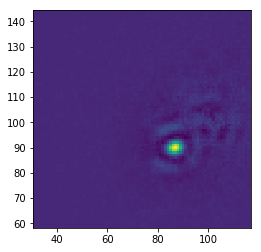

In [102]:
xpsf = xpix*201./2048.
ypsf = ypix*201./2048.
plt.figure(k+4)
plt.imshow(psf, cmap='viridis')               #psf with adjusted scaling
plt.xlim(xpsf-sp, xpsf+sp)
plt.ylim(ypsf-sp, ypsf+sp)
print xpix, ypix
#plt.axis('off')
plt.show()

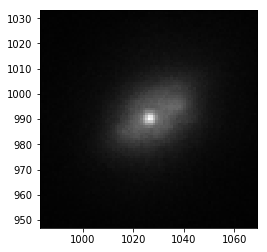

In [71]:
#plt.figure(k+6)                                                     #keep all plots seperate
#plt.imshow(psf, cmap='gray', vmin=-2.e0, vmax=2.e0)               #log plot, vmin and max to adjust scaling
#plt.axis('off')
#plt.plot(xpix-220, ypix, 's', marker='_', mew=4, ms=20, color='lawngreen')     #mark target's position by pixel coordinates
#plt.plot(xpix+220, ypix, 's', marker='_', mew=4, ms=20, color='lawngreen')
plt.show()
plt.figure(k+7)                                                     #keep all plots seperate
plt.imshow(ftsim, cmap='gray')               #log plot, vmin and max to adjust scaling
plt.xlim(xpix-sp, xpix+sp)
plt.ylim(ypix-sp, ypix+sp)
plt.show()

In [68]:
ftsimcut = ftsim
av = np.mean(ftsim)*40
for i in ftsimcut:
    for idx, k in enumerate(i):
        if k>av:
            i[idx]=0
print np.mean(ftsimcut), np.mean(ftsim)

0.79469 0.79469


In [69]:
plt.figure(k+600, frameon=False)
fig.set_size_inches(10,10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(ftsim, cmap='magma')                          #color scaling
plt.xlim(xpix-232, xpix+232)                            #Crop out to 8 arc seconds (total width of field): 8*1000/(17.4*2)
plt.ylim(ypix-232, ypix+232)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.savefig(j+'/flft.png', dpi=100, bbox_inches='tight', pad_inches=0)
k+=1

In [14]:
#FITS COLLAGE (4 pngs)
plt.figure(k+1)
plt.imshow(ftsim, cmap='gray')                              #black and white original fits
plt.xlim(xpix-sp, xpix+sp)                                  #crop plot based on arcsec specifications
plt.ylim(ypix-sp, ypix+sp)
plt.axis('off')
plt.savefig(j+'/fc1.png', bbox_inches='tight', pad_inches=0)
dimg = (Image.open(j+'/fc1.png')).crop((33, 3, 251, 220)) #.crop(coordinates of upper left corner, coordinates of lower right)
dimg.save(j+'/fc1.png', 'PNG')                              #resave cropped image as png
dimg.close()

plt.figure(k+3)
plt.imshow(psf, cmap='viridis')                                #color psf
plt.xlim(xpsf-sp, xpsf+sp)
plt.ylim(ypsf-sp, ypsf+sp)
plt.axis('off')
plt.savefig(j+'/fc3.png', bbox_inches='tight', pad_inches=0)
dimg = (Image.open(j+'/fc3.png')).crop((26, 3, 244, 220))
dimg.save(j+'/fc3.png', 'PNG')                              #resave cropped image as png
dimg.close()

In [21]:
plt.figure(k+6)                                                     #keep all plots seperate
plt.imshow(ftslg, cmap='gray', vmin=-2.e0, vmax=2.e0)               #log plot, vmin and max to adjust scaling
plt.axis('off')
plt.plot(xpix-220, ypix, 's', marker='_', mew=4, ms=20, color='lawngreen')      #mark target's position by pixel coordinates
plt.plot(xpix+220, ypix, 's', marker='_', mew=4, ms=20, color='lawngreen')      #(position, marker, thicknes, length, color)
plt.savefig(j+'/locda.png', bbox_inches='tight', pad_inches=0)      #save plot
dimg = (Image.open(j+'/locda.png'))#.crop((35, 5, 250, 220))         #open saved plot and crop
dimg.save(j+'/locda.png', 'PNG')                                    #re-save
dimg.close()

Working on: test4\3_J0847+2920_VIC_Si_o_20160129_083340.042442,  1/8
Working on: test4\3_J1050+3942_VIC_Si_o_20160129_103019.040687,  2/8
Working on: test4\3_J1158+4239_VIC_Si_o_20170529_033711.042091,  3/8
Working on: test4\3_J1219+0214_VIC_Si_o_20170607_042905.041555,  4/8
Working on: test4\3_J1221+6816_VIC_Si_o_20170522_052907.045196,  5/8
Working on: test4\3_J1222+0150E_VIC_Si_o_20170607_042601.044693,  6/8
Working on: test4\3_J1314+1320_VIC_Si_o_20170222_111119.042614,  7/8
Working on: test4\3_J1726+2244_VIC_Si_o_20170408_101608.042746,  8/8


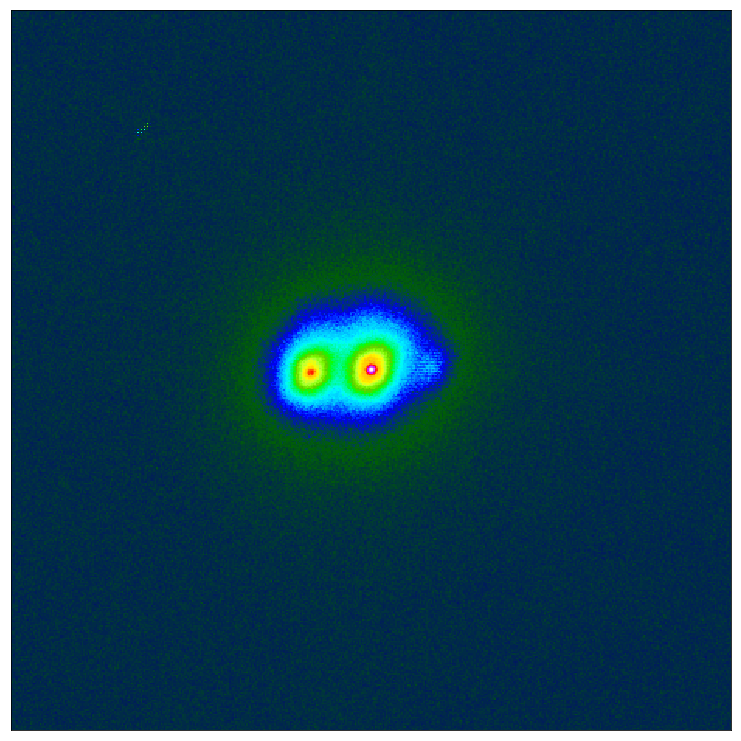

In [12]:
cct = 0.10                                                            #core cut
if not os.path.exists(nwfl):
    os.mkdir(nwfl)
arcssp = 1.5                                                        #arc seconds across total image for fits collage
sp = arcssp*(1000./(17.4*2.))                                       #converting arcsec to pixels on either side of target
trgtlst = sorted(glob.glob(path))
k=0                                                                 #Make sure all plots are seperate
m=1                                                                 #keep track of loop
for j in trgtlst:                                                   #loop over every target directory
    
    print 'Working on: ' + j.split("/")[-1]+',  '+str(m)+'/'+str(len(trgtlst))   #print current target and progress
    if m<8:
        m+=1
        continue
    
    #ONLY LOOK AT OBJECTS WITH CORE >= 0.1
    stinfo = sorted(glob.glob(j + '/automated/strehl/*.txt'))
    with open(stinfo[0], 'r') as st:
        tinf = st.readlines()[1].split()            #target info

    ntd = nwfl+'/'+names[m-1]                      #new target directory
    if not os.path.exists(ntd):
        os.mkdir(ntd)
    
    #LOADING FILES
    fts = j+'/automated/100p.fits'                                          #100p fits file
    ftsim= fits.getdata(fts)                                                #load fits file and store as array
    old = np.seterr(invalid='ignore')                                       #ignore invalid values for taking log in next line
    ftslg = np.log(ftsim+50)                                                #for log plots
    np.seterr(**old)                                                        #restore settings to not ignore invalid values
    psf = fits.getdata((sorted(glob.glob(j+'/automated/pca/*.fits')))[0])   #load psf fits file and store as array
    
    contcurv = sorted(glob.glob(j+'/automated/pca/*curve.png'))
    copyfile(contcurv[0], ntd+'/contrast_curve.png')
    
    #CREATE ONE TEXT FILE FOR GUI
    tinfr = []                                      #Blank array to store target info
    for i in tinf:
        if i != tinf[-1] and i != tinf[-2]:         #Remove tag and FWHM, last two items in strehl txt
            tinfr.append(round(float(i), 2))        #round to two sf, convert back to string
    hdulist = fits.open(fts)
    tinfr.append(hdulist[0].header['MAGNITUD'])     #Get object magnitude from header
    np.savetxt(ntd+'/info4GUI.txt', tinfr)
    
    xpix = int(tinfr[1])                            #get pixel coordinates of target
    ypix = int(tinfr[0])
    xpsf = 100                                      #pixel coordinates of target for psf images
    ypsf = 100                                      #..since psf has target centered
    
    
    
    #Larger Field Image (with bright pixels 'cut out')
    ftsimcut = ftsim.copy()
    fig = plt.figure(k+5, frameon=False)
    fig.set_size_inches(10,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    ax.imshow(ftslg, cmap='gist_heat')                          #color scaling
    plt.xlim(xpix-232, xpix+232)                            #Crop out to 8 arc seconds (total width of field): 8*1000/(17.4*2)
    plt.ylim(ypix-232, ypix+232)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.savefig(nwfl+'/gist_ncar/'+str(m), dpi=100, bbox_inches='tight', pad_inches=0)
    m+=1

In [11]:
np.std(ftsim), np.mean(ftsim)

(3.2705581, 0.43813318)